# Case 1 — EDA (клиенты и транзакции, 3 месяца)


In [ ]:

import os, glob, json, math
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)



In [ ]:
from pathlib import Path
import pandas as pd
import glob
import numpy as np

BASE = Path("data")               
TX_DIR = BASE / "transactions"    

clients = pd.read_csv(BASE / "clients.csv")
clients.columns = [c.strip() for c in clients.columns]

# 1) Транзакции (покупки)
tx_files = sorted(glob.glob(str(TX_DIR / "client_*_transactions_3m.csv")))
tx_frames = [pd.read_csv(p, sep=None, engine="python") for p in tx_files]  
tx = pd.concat(tx_frames, ignore_index=True) if tx_frames else pd.DataFrame()
tx.columns = [c.strip() for c in tx.columns]

# 2) Переводы (in/out)
tr_files = sorted(glob.glob(str(TX_DIR / "client_*_transfers_3m.csv")))
tr_frames = [pd.read_csv(p, sep=None, engine="python") for p in tr_files]
tr = pd.concat(tr_frames, ignore_index=True) if tr_frames else pd.DataFrame()
tr.columns = [c.strip() for c in tr.columns]

tx["date"] = pd.to_datetime(tx.get("date"), errors="coerce")
tr["date"] = pd.to_datetime(tr.get("date"), errors="coerce")

for df in (tx, tr):
    if "amount" in df.columns:
        df["amount"] = pd.to_numeric(df["amount"], errors="coerce").fillna(0.0)
    for col in ("category","currency","type","direction"):
        if col in df.columns:
            df[col] = df[col].fillna("").astype(str)

rates = {"KZT":1.0, "USD":500.0, "EUR":540.0, "RUB":5.0}
def to_kzt(amount, currency):
    try:
        r = rates.get(str(currency).upper(), 1.0)
        return float(amount) * float(r)
    except Exception:
        return 0.0
    

tx["amount"] = pd.to_numeric(tx.get("amount", 0), errors="coerce").fillna(0.0)
tx["amount"] = tx.apply(lambda r: to_kzt(r["amount"], r["currency"]), axis=1)
tx["currency"] = "KZT"

display(clients.head(2))
display(tx.head(2))
display(tr.head(2))
print("clients:", clients.shape, "tx:", tx.shape, "tr:", tr.shape)

,client_code,name,status,age,city,avg_monthly_balance_KZT
0,1,Айгерим,Зарплатный клиент,29,Алматы,92643
1,2,Данияр,Премиальный клиент,41,Астана,1577073


,﻿client_code,name,product,status,city,date,category,amount,currency
0,10,Карина,Премиальная карта,зп,Усть-Каменогорск,2025-06-01 08:10:05,Кино,3338.23,KZT
1,10,Карина,Премиальная карта,зп,Усть-Каменогорск,2025-06-01 12:10:01,Продукты питания,27765.82,KZT


,﻿client_code,name,product,status,city,date,type,direction,amount,currency
0,10,Карина,Премиальная карта,зп,Усть-Каменогорск,2025-06-02 10:23:51,card_out,out,35785.68,KZT
1,10,Карина,Премиальная карта,зп,Усть-Каменогорск,2025-06-02 19:00:30,card_out,out,15445.36,KZT


clients: (60, 6) tx: (17400, 9) tr: (18000, 10)


currency
KZT    17400
Name: count, dtype: int64

In [72]:
from pathlib import Path
import pandas as pd
import glob
import numpy as np

for i in range(1, 2):
    if i == 34:
        continue
    client_tx = pd.read_csv(rf"S:\PYTHON_VS\case1\data\transactions\client_{i}_transactions_3m.csv")
    client_tr = pd.read_csv(rf"S:\PYTHON_VS\case1\data\transactions\client_{i}_transfers_3m.csv")

    name = client_tx["name"][0]
    product = client_tx["product"][0]

    print(f"{name = }, {product = }")

    display(client_tx["category"].value_counts())
    display(client_tr["type"].value_counts())
    display(client_tr["direction"].value_counts()[:6])

name = 'Айгерим', product = 'Карта для путешествий'


category
Кафе и рестораны    68
Такси               48
Продукты питания    44
Едим дома           33
Смотрим дома        31
Кино                31
Играем дома         30
АЗС                  8
Путешествия          3
Отели                3
Развлечения          1
Name: count, dtype: int64

type
card_out            165
p2p_out              60
atm_withdrawal       18
utilities_out        15
card_in              15
cashback_in           9
loan_payment_out      9
refund_in             6
salary_in             3
Name: count, dtype: int64

direction
out    267
in      33
Name: count, dtype: int64

name = 'Данияр', product = 'Карта для путешествий'
category
Кафе и рестораны    66
Продукты питания    57
Такси               44
Едим дома           34
Кино                30
Смотрим дома        29
Играем дома         25
АЗС                  9
Отели                3
Путешествия          2
Развлечения          1
Name: count, dtype: int64

type
card_out            165
p2p_out              60
atm_withdrawal       18
utilities_out        15
card_in              15
loan_payment_out      9
cashback_in           9
refund_in             6
salary_in             3
Name: count, dtype: int64

direction
out    267
in      33
Name: count, dtype: int64

Данияр


product
Карта для путешествий    300
Name: count, dtype: int64

type
card_out            165
p2p_out              60
atm_withdrawal       18
utilities_out        15
card_in              15
loan_payment_out      9
cashback_in           9
refund_in             6
salary_in             3
Name: count, dtype: int64

direction
out    267
in      33
Name: count, dtype: int64

In [ ]:

# Валютные курсы (оффлайн дефолты).
rates = {"KZT":1.0, "USD":500.0, "EUR":540.0, "RUB":5.0}
def to_kzt(amount, currency):
    try:
        r = rates.get(str(currency).upper(), 1.0)
        return float(amount) * float(r)
    except Exception:
        return 0.0

tx["amount"] = pd.to_numeric(tx.get("amount", 0), errors="coerce").fillna(0.0)
tx["amount_kzt"] = tx.apply(lambda r: to_kzt(r["amount"], r["currency"]), axis=1)


In [ ]:

print("Clients NA per column:")
display(clients.isna().sum())

if not tx.empty:
    print("Tx NA per column:")
    display(tx.isna().sum())
    print("Категорий уникально:", tx["category"].nunique())
    print("Валют уникально:", tx["currency"].str.upper().nunique())


Clients NA per column:


client_code                0
name                       0
status                     0
age                        0
city                       0
avg_monthly_balance_KZT    0
dtype: int64

Tx NA per column:


client_code    0
name            0
product         0
status          0
city            0
date            0
category        0
amount          0
currency        0
amount_kzt      0
dtype: int64

Категорий уникально: 12
Валют уникально: 2


In [5]:
display(clients.head(2))
display(tx.head(2))
display(tr.head(2))

,client_code,name,status,age,city,avg_monthly_balance_KZT
0,1,Айгерим,Зарплатный клиент,29,Алматы,92643
1,2,Данияр,Премиальный клиент,41,Астана,1577073


,﻿client_code,name,product,status,city,date,category,amount,currency,amount_kzt
0,10,Карина,Премиальная карта,зп,Усть-Каменогорск,2025-06-01 08:10:05,Кино,3338.23,KZT,3338.23
1,10,Карина,Премиальная карта,зп,Усть-Каменогорск,2025-06-01 12:10:01,Продукты питания,27765.82,KZT,27765.82


,﻿client_code,name,product,status,city,date,type,direction,amount,currency
0,10,Карина,Премиальная карта,зп,Усть-Каменогорск,2025-06-02 10:23:51,card_out,out,35785.68,KZT
1,10,Карина,Премиальная карта,зп,Усть-Каменогорск,2025-06-02 19:00:30,card_out,out,15445.36,KZT


In [6]:
display(tx.value_counts("currency"))
display(tr.value_counts("currency"))
display(tx.value_counts("category"))
display(tr.value_counts("direction"))

currency
KZT    17365
EUR       35
Name: count, dtype: int64

currency
KZT    18000
Name: count, dtype: int64

category
Кафе и рестораны          3652
Продукты питания          2948
Такси                     2901
Едим дома                 1922
Смотрим дома              1856
Играем дома               1809
Кино                      1648
АЗС                        432
Косметика и Парфюмерия     118
Отели                       54
Путешествия                 35
Развлечения                 25
Name: count, dtype: int64

direction
out    15813
in      2187
Name: count, dtype: int64

In [7]:

# clients
# tx
tx["date"] = pd.to_datetime(tx.get("date"), errors="coerce")
for col in ("category","currency","client_code"):
    if col in tx.columns:
        tx[col] = tx[col].fillna("").astype(str)
tx["amount"] = pd.to_numeric(tx.get("amount", 0.0), errors="coerce").fillna(0.0)
tx["amount_kzt"] = tx.apply(lambda r: to_kzt(r["amount"], r["currency"]), axis=1)
tx["ym"] = tx["date"].dt.to_period("M")

# tr
tr["date"] = pd.to_datetime(tr.get("date"), errors="coerce")
for col in ("type","direction","currency","client_code"):
    if col in tr.columns:
        tr[col] = tr[col].fillna("").astype(str)
tr["amount"] = pd.to_numeric(tr.get("amount", 0.0), errors="coerce").fillna(0.0)
tr["amount_kzt"] = tr.apply(lambda r: to_kzt(r["amount"], r["currency"]), axis=1)
tr["ym"] = tr["date"].dt.to_period("M")


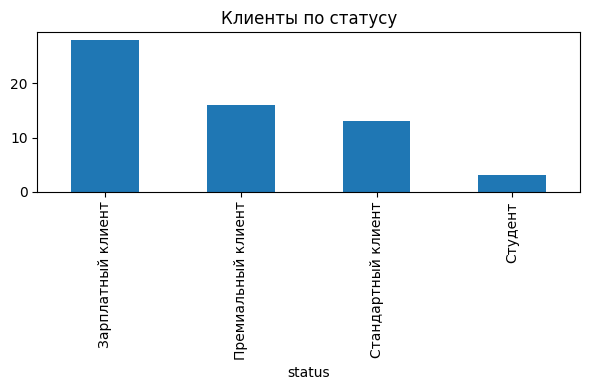

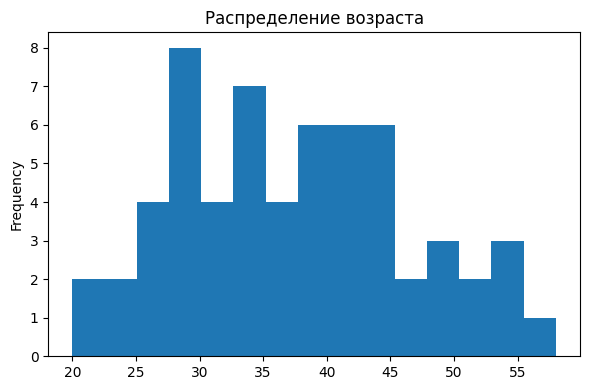

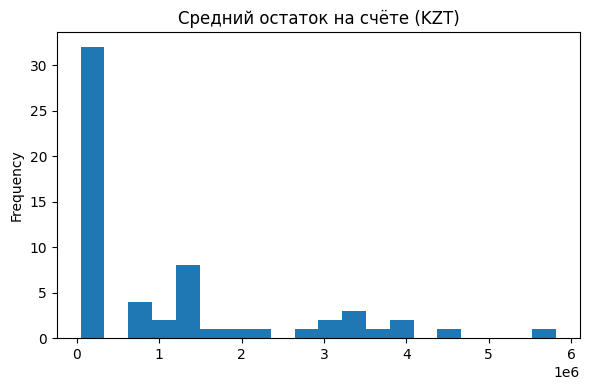

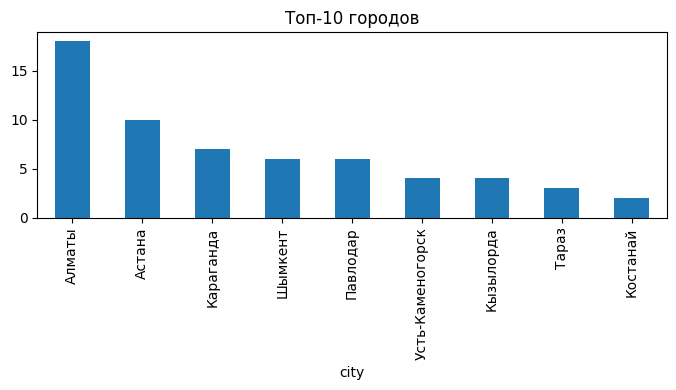

In [ ]:

# Кол-во клиентов по статусу
fig = plt.figure(figsize=(6,4))
clients["status"].value_counts().plot(kind="bar", title="Клиенты по статусу")
plt.tight_layout(); plt.show()

# Возраст
fig = plt.figure(figsize=(6,4))
clients["age"].dropna().astype(int).plot(kind="hist", bins=15, title="Распределение возраста")
plt.tight_layout(); plt.show()

# Средний остаток
fig = plt.figure(figsize=(6,4))
clients["avg_monthly_balance_KZT"].plot(kind="hist", bins=20, title="Средний остаток на счёте (KZT)")
plt.tight_layout(); plt.show()

# Топ-10 городов
fig = plt.figure(figsize=(7,4))
clients["city"].value_counts().head(10).plot(kind="bar", title="Топ-10 городов")
plt.tight_layout(); plt.show()


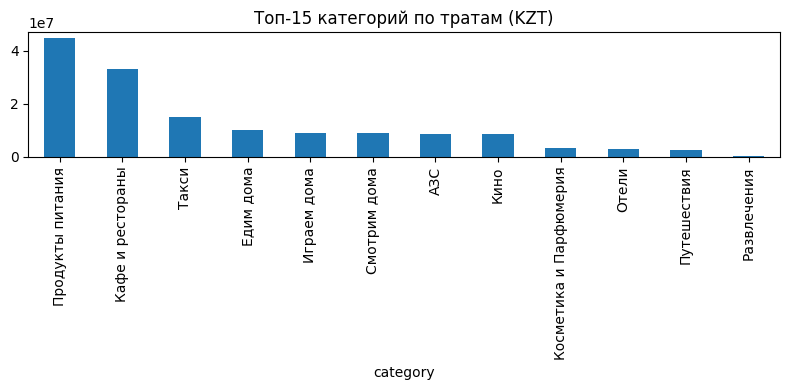

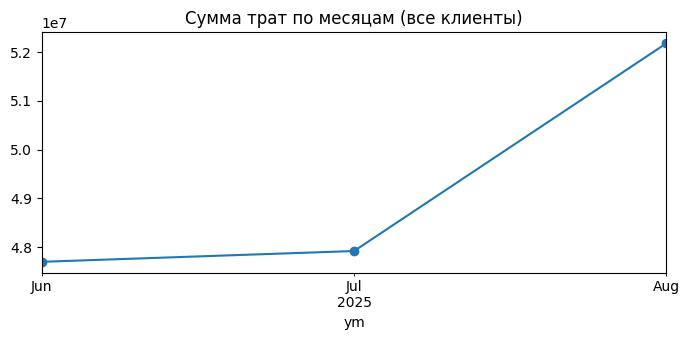

FX-доля по покупкам: 0.43%


In [9]:

if not tx.empty:
    # Топ-15 категорий по сумме
    cat_sum = tx.groupby("category")["amount_kzt"].sum().sort_values(ascending=False).head(15)
    fig = plt.figure(figsize=(8,4))
    cat_sum.plot(kind="bar", title="Топ-15 категорий по тратам (KZT)")
    plt.tight_layout(); plt.show()

    # Помесячная динамика (все клиенты)
    by_month = tx.groupby("ym")["amount_kzt"].sum()
    fig = plt.figure(figsize=(7,3.5))
    by_month.plot(kind="line", marker="o", title="Сумма трат по месяцам (все клиенты)")
    plt.tight_layout(); plt.show()

    # FX-доля
    total = tx["amount_kzt"].sum()
    fx = tx.loc[tx["currency"].str.upper().ne("KZT"), "amount_kzt"].sum()
    fx_share = (fx/total) if total>0 else 0.0
    print(f"FX-доля по покупкам: {fx_share:.2%}")


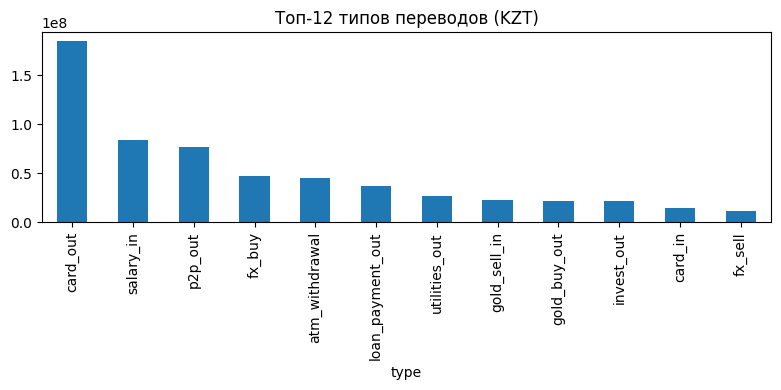

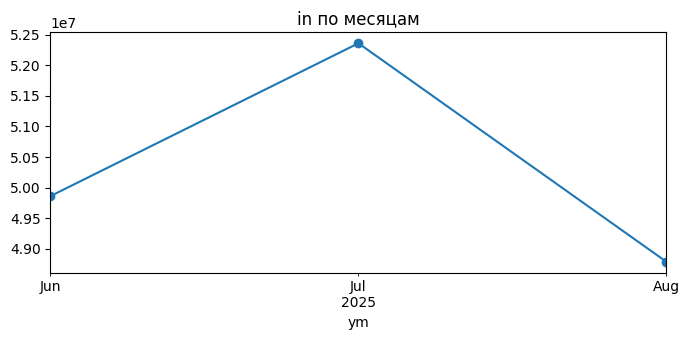

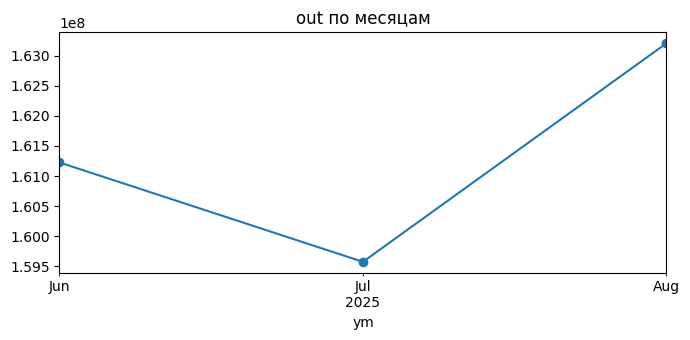

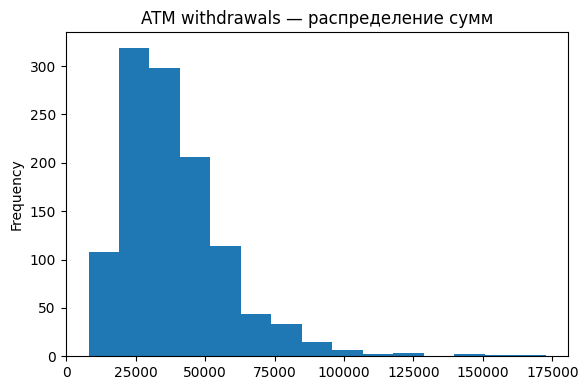

In [10]:

if not tr.empty:
    # Топ-12 типов переводов по сумме
    typ_sum = tr.groupby("type")["amount_kzt"].sum().sort_values(ascending=False).head(12)
    fig = plt.figure(figsize=(8,4))
    typ_sum.plot(kind="bar", title="Топ-12 типов переводов (KZT)")
    plt.tight_layout(); plt.show()

    # In vs Out по месяцам
    piv = tr.pivot_table(index="ym", columns="direction", values="amount_kzt", aggfunc="sum").fillna(0)
    for col in piv.columns:
        fig = plt.figure(figsize=(7,3.5))
        piv[col].plot(kind="line", marker="o", title=f"{col} по месяцам")
        plt.tight_layout(); plt.show()

    # Пример: распределение снятий в банкоматах
    atm = tr.loc[tr["type"].eq("atm_withdrawal"), "amount_kzt"]
    if not atm.empty:
        fig = plt.figure(figsize=(6,4))
        atm.plot(kind="hist", bins=15, title="ATM withdrawals — распределение сумм")
        plt.tight_layout(); plt.show()


In [ ]:

import re

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    # нижний регистр, срез пробелов, пробелы и «экзотика» → подчеркивания
    mapping = {c: re.sub(r'[^a-z0-9_]', '_', c.strip().lower()) for c in df.columns}
    return df.rename(columns=mapping)

def ensure_client_code(df: pd.DataFrame, df_name="df") -> pd.DataFrame:
    if "client_code" in df.columns:
        return df
    cand = [c for c in df.columns if "client" in c and ("code" in c or "id" in c)]
    if cand:
        return df.rename(columns={cand[0]: "client_code"})
    raise KeyError(f"{df_name}: не нашли колонку client_code (после нормализации: {list(df.columns)})")

clients = normalize_cols(clients)
tx      = normalize_cols(tx)
tr      = normalize_cols(tr)

clients = ensure_client_code(clients, "clients")
if not tx.empty:
    tx = ensure_client_code(tx, "tx")
if not tr.empty:
    tr = ensure_client_code(tr, "tr")

clients["client_code"] = clients["client_code"].astype(str)
if "client_code" in tx.columns:
    tx["client_code"] = tx["client_code"].astype(str)
if "client_code" in tr.columns:
    tr["client_code"] = tr["client_code"].astype(str)

for df, name in [(tx,"tx"), (tr,"tr")]:
    if df.empty: 
        continue
    for c in ["date","amount","currency"]:
        if c not in df.columns:
            print(f"[WARN] {name}: нет колонки {c} — проверь входные файлы")

print("OK cols:", clients.columns.tolist()[:8], "...", " | tx:", list(tx.columns)[:8], " | tr:", list(tr.columns)[:8])


tx_groups = {str(k): g for k, g in (tx.groupby("client_code") if not tx.empty else [])}
tr_groups = {str(k): g for k, g in (tr.groupby("client_code") if not tr.empty else [])}

ONLINE = {"Едим дома","Смотрим дома","Играем дома"}
TRAVEL = {"Путешествия","Отели","Такси"}

def monthly_totals(df, col="amount_kzt"):
    if df.empty: return {}
    tmp = df.copy()
    tmp["ym"] = tmp["date"].dt.to_period("M")
    s = tmp.groupby("ym")[col].sum()
    return {str(k): float(v) for k, v in s.items()}

def get_num_from_row(row, *aliases, default=0.0):
    """Достаёт число по одному из возможных имён колонки (безопасно).
       Чистит пробелы/нецифры, поддерживает ',' как десятичный разделитель."""
    for key in aliases:
        if key in row and pd.notna(row[key]):
            s = str(row[key]).replace('\xa0', '').replace(' ', '')
            s = re.sub(r'[^0-9,.\-]', '', s).replace(',', '.')
            try:
                return float(s)
            except Exception:
                pass
    return float(default)

rows = []
for _, p in clients.iterrows():
    code = str(p.get("client_code"))
    df_tx = tx_groups.get(code, pd.DataFrame(columns=tx.columns))
    df_tr = tr_groups.get(code, pd.DataFrame(columns=tr.columns))

    if df_tx.empty:
        spend_cat = {}; total_spend = 0.0
        fx_share_tx = 0.0
        months_tx = {}
    else:
        spend_cat = df_tx.groupby("category")["amount_kzt"].sum().to_dict()
        total_spend = sum(spend_cat.values())
        tot = df_tx["amount_kzt"].sum()
        fx_amt = df_tx.loc[df_tx["currency"].str.upper().ne("KZT"), "amount_kzt"].sum()
        fx_share_tx = (fx_amt/tot) if tot>0 else 0.0
        months_tx = monthly_totals(df_tx)

    online_share = (sum(spend_cat.get(c,0.0) for c in ONLINE)/total_spend) if total_spend>0 else 0.0
    travel_share = (sum(spend_cat.get(c,0.0) for c in TRAVEL)/total_spend) if total_spend>0 else 0.0

    if df_tr.empty:
        in_sum = out_sum = 0.0
        salary_in = stipend_in = cashback_in = refund_in = 0.0
        p2p_out = card_out = atm_withdrawal = utilities_out = 0.0
        loan_payment_out = cc_repayment_out = installment_payment_out = 0.0
        invest_in = invest_out = deposit_topup_out = 0.0
        gold_buy_out = gold_sell_in = 0.0
        months_tr_in = months_tr_out = {}
    else:
        in_sum  = df_tr.loc[df_tr["direction"].eq("in"), "amount_kzt"].sum()
        out_sum = df_tr.loc[df_tr["direction"].eq("out"), "amount_kzt"].sum()

        def s(tp): return df_tr.loc[df_tr["type"].eq(tp), "amount_kzt"].sum()
        salary_in = s("salary_in"); stipend_in = s("stipend_in")
        cashback_in = s("cashback_in"); refund_in = s("refund_in")
        p2p_out = s("p2p_out"); card_out = s("card_out"); atm_withdrawal = s("atm_withdrawal")
        utilities_out = s("utilities_out"); loan_payment_out = s("loan_payment_out")
        cc_repayment_out = s("cc_repayment_out"); installment_payment_out = s("installment_payment_out")
        invest_in = s("invest_in"); invest_out = s("invest_out")
        deposit_topup_out = s("deposit_topup_out")
        gold_buy_out = s("gold_buy_out"); gold_sell_in = s("gold_sell_in")

        months_tr_in  = monthly_totals(df_tr.loc[df_tr["direction"].eq("in")])
        months_tr_out = monthly_totals(df_tr.loc[df_tr["direction"].eq("out")])
    
    rows.append({
        "client_code": code,
        "status": str(p.get("status","")),
        "age": float(p.get("age", np.nan)) if pd.notna(p.get("age", np.nan)) else np.nan,
        "avg_balance": float(p.get("avg_monthly_balance_kzt", 0.0) or 0.0),

        "total_spend_3m": float(total_spend),
        "share_online": float(online_share),
        "share_travel": float(travel_share),
        "fx_share_tx": float(fx_share_tx),
        "months_seen_tx": int(len(months_tx)),
        "month_spend_mean": float(np.mean(list(months_tx.values()))) if months_tx else 0.0,
        "month_spend_std":  float(np.std(list(months_tx.values()))) if months_tx else 0.0,

        "transfers_in_3m": float(in_sum),
        "transfers_out_3m": float(out_sum),
        "net_flow_3m": float(in_sum - out_sum),

        "salary_in": float(salary_in),
        "stipend_in": float(stipend_in),
        "cashback_in": float(cashback_in),
        "refund_in": float(refund_in),

        "p2p_out": float(p2p_out),
        "card_out": float(card_out),
        "atm_withdrawal": float(atm_withdrawal),
        "utilities_out": float(utilities_out),
        "loan_payment_out": float(loan_payment_out),
        "cc_repayment_out": float(cc_repayment_out),
        "installment_payment_out": float(installment_payment_out),

        "invest_in": float(invest_in),
        "invest_out": float(invest_out),
        "deposit_topup_out": float(deposit_topup_out),
        "gold_buy_out": float(gold_buy_out),
        "gold_sell_in": float(gold_sell_in),
    })

feat = pd.DataFrame(rows)
feat = feat.merge(clients[["client_code","city"]], on="client_code", how="left")
feat.head(10)


OK cols: ['client_code', 'name', 'status', 'age', 'city', 'avg_monthly_balance_kzt'] ...  | tx: ['client_code', 'name', 'product', 'status', 'city', 'date', 'category', 'amount']  | tr: ['client_code', 'name', 'product', 'status', 'city', 'date', 'type', 'direction']


,client_code,status,age,avg_balance,total_spend_3m,share_online,share_travel,fx_share_tx,months_seen_tx,month_spend_mean,month_spend_std,transfers_in_3m,transfers_out_3m,net_flow_3m,salary_in,stipend_in,cashback_in,refund_in,p2p_out,card_out,atm_withdrawal,utilities_out,loan_payment_out,cc_repayment_out,installment_payment_out,invest_in,invest_out,deposit_topup_out,gold_buy_out,gold_sell_in,city
0,1,Зарплатный клиент,29.0,92643.0,2626914.27,0.184009,0.244409,0.000000,3,8.756381e+05,172513.468114,1875090.64,6722190.40,-4847099.76,1446421.73,0.00,138273.34,114471.50,1274129.26,3829951.76,617946.71,492152.41,508010.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Алматы
1,2,Премиальный клиент,41.0,1577073.0,2623272.32,0.180276,0.166927,0.000000,3,8.744241e+05,89349.195422,1646273.33,6636050.47,-4989777.14,1278082.01,0.00,107537.19,55248.95,1305706.44,3652000.64,775789.21,396920.77,505633.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Астана
2,3,Студент,22.0,63116.0,2272999.63,0.198575,0.320537,0.280208,3,7.576665e+05,251780.894628,690885.17,3526821.01,-2835935.84,0.00,124207.58,187247.61,60804.20,496377.33,1315353.95,759624.87,395640.68,559824.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Алматы
3,4,Зарплатный клиент,36.0,83351.0,2540993.42,0.177756,0.241687,0.000000,3,8.469978e+05,165135.314667,1786681.16,6103937.34,-4317256.18,1372775.52,0.00,107111.63,61478.54,1170717.90,3312986.71,634755.85,453960.22,531516.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Караганда
4,5,Премиальный клиент,45.0,1336536.0,2703671.00,0.199707,0.237067,0.000000,3,9.012237e+05,182854.492842,1746521.40,6200126.04,-4453604.64,1262119.01,0.00,126590.18,74928.97,1261804.77,3344845.96,590493.11,454938.05,548044.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Алматы
5,6,Стандартный клиент,34.0,131929.0,2670256.87,0.159337,0.220022,0.000000,3,8.900856e+05,131759.369281,1828401.34,6432809.25,-4604407.91,1378299.83,0.00,109520.75,60443.57,1331551.75,3619748.11,629865.51,370190.08,481453.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Шымкент
6,7,Премиальный клиент,48.0,4040997.0,2701821.89,0.178182,0.087017,0.000000,3,9.006073e+05,162336.753215,1798855.62,8422453.40,-6623597.78,1197030.77,0.00,182859.58,132023.71,1572706.70,4110840.27,1193728.17,557691.12,987487.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Алматы
7,8,Зарплатный клиент,33.0,1058403.0,3215125.84,0.161322,0.073257,0.000000,3,1.071709e+06,37334.055039,2044952.12,8494299.18,-6449347.06,1349955.04,0.00,266820.85,109128.90,1730533.82,4048995.40,1162883.30,609707.88,942178.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Астана
8,9,Премиальный клиент,55.0,3084180.0,2823888.90,0.163584,0.079068,0.000000,3,9.412963e+05,101118.252239,1783301.11,8565700.19,-6782399.08,1205500.19,0.00,188381.32,92987.82,1825147.95,4138180.77,1115664.13,551803.57,934903.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Алматы
9,10,Зарплатный клиент,38.0,1277325.0,2919534.74,0.141674,0.068140,0.000000,3,9.731782e+05,38041.966619,1978310.07,8538828.01,-6560517.94,1293311.35,0.00,184539.23,208027.80,1774833.09,4160053.26,1251711.25,562785.97,789444.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Усть-Каменогорск


# Визуализация по сводной витрине (несколько примеров)


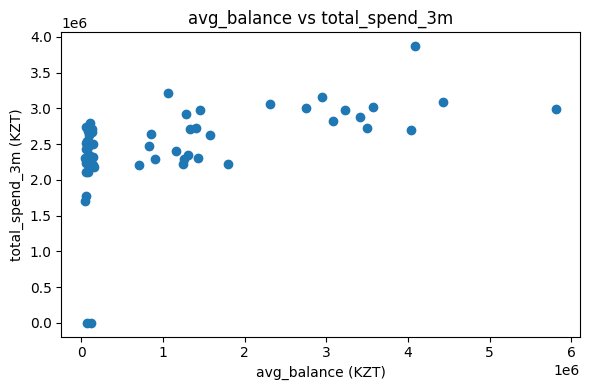

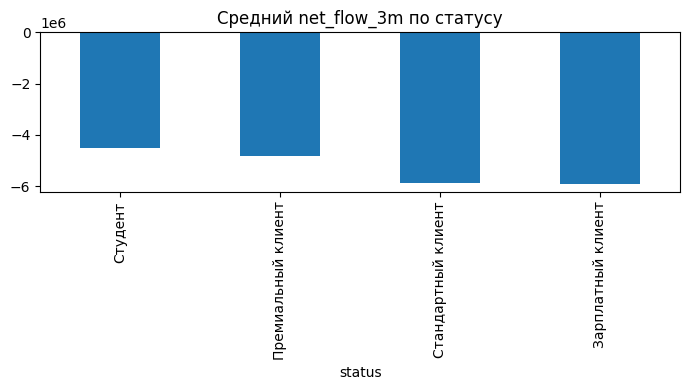

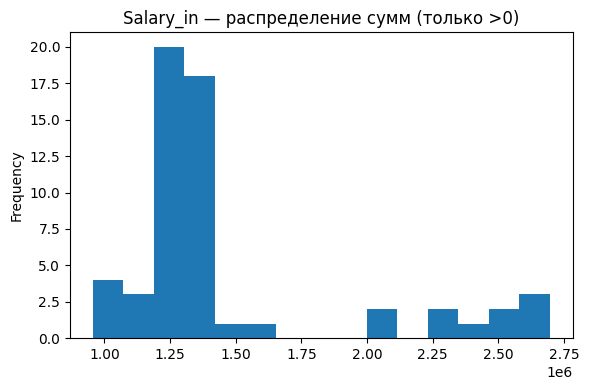

In [ ]:

fig = plt.figure(figsize=(6,4))
plt.scatter(feat["avg_balance"], feat["total_spend_3m"])
plt.xlabel("avg_balance (KZT)"); plt.ylabel("total_spend_3m (KZT)")
plt.title("avg_balance vs total_spend_3m")
plt.tight_layout(); plt.show()

fig = plt.figure(figsize=(7,4))
feat.groupby("status")["net_flow_3m"].mean().sort_values(ascending=False).plot(kind="bar", title="Средний net_flow_3m по статусу")
plt.tight_layout(); plt.show()

if (feat["salary_in"]>0).any():
    fig = plt.figure(figsize=(6,4))
    feat.loc[feat["salary_in"]>0, "salary_in"].plot(kind="hist", bins=15, title="Salary_in — распределение сумм (только >0)")
    plt.tight_layout(); plt.show()


# Корреляции (Pearson и Spearman) + heatmap (matplotlib)

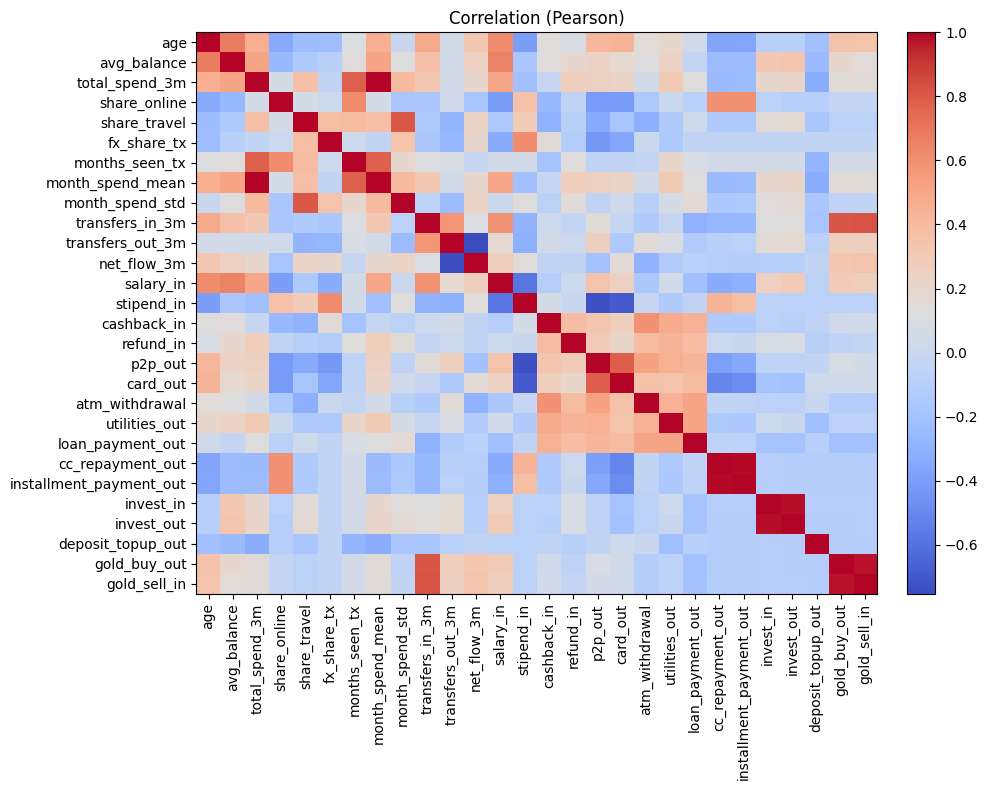

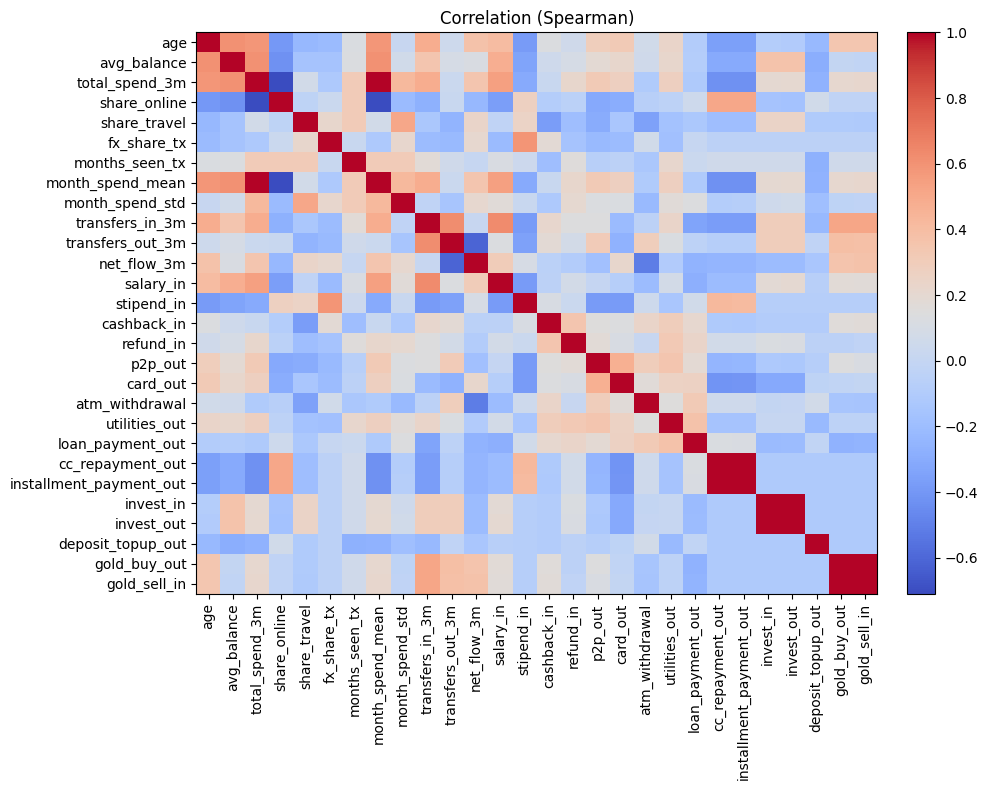

In [ ]:


num_cols = [
    "age","avg_balance","total_spend_3m","share_online","share_travel","fx_share_tx",
    "months_seen_tx","month_spend_mean","month_spend_std",
    "transfers_in_3m","transfers_out_3m","net_flow_3m",
    "salary_in","stipend_in","cashback_in","refund_in",
    "p2p_out","card_out","atm_withdrawal","utilities_out",
    "loan_payment_out","cc_repayment_out","installment_payment_out",
    "invest_in","invest_out","deposit_topup_out","gold_buy_out","gold_sell_in"
]

corr_p = feat[num_cols].corr(method="pearson")
corr_s = feat[num_cols].corr(method="spearman")

def plot_heatmap(corr, title, cmap="coolwarm"):
    fig = plt.figure(figsize=(10,8))
    im = plt.imshow(corr.values, aspect="auto", cmap=cmap) 
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

plot_heatmap(corr_p, "Correlation (Pearson)")
plot_heatmap(corr_s, "Correlation (Spearman)")


In [20]:
feat_path = Path("outputs"); feat_path.mkdir(parents=True, exist_ok=True)
feat.to_csv(feat_path / "client_feature_store.csv", index=False, encoding="utf-8")
print("Saved:", feat_path / "client_feature_store.csv")

Saved: outputs\client_feature_store.csv
